# **Data Pre-processing**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Importing libraries
import pandas as pd # with pandas library we can work with csv file
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Datasets For Machine Learning/monthly-milk-production-pounds.csv',parse_dates=['Month'])


```
The parse_dates=['Month'] argument tells pandas to try and convert the 'Month' column into datetime objects,  
which is crucial for time series analysis.
```

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 2 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Month                                                     169 non-null    object 
 1   Monthly milk production: pounds per cow. Jan 62 ? Dec 75  168 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.8+ KB


In [5]:
df.head()

,Month,Monthly milk production: pounds per cow. Jan 62 ? Dec 75
0,1962-01,589.0
1,1962-02,561.0
2,1962-03,640.0
3,1962-04,656.0
4,1962-05,727.0


It is a time series data. The output is varying with time.

<Axes: >

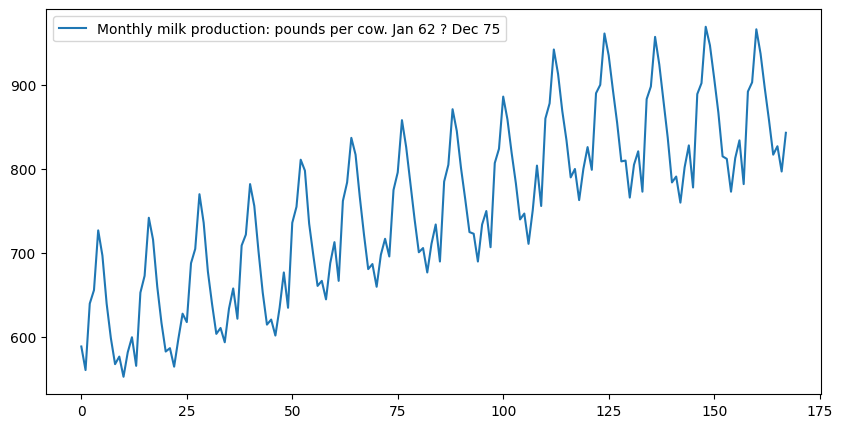

In [6]:
df.plot(figsize=(10,5))

There is seasonality and trend.

In [7]:
df.isnull().sum() #finding null values

,0
Month,0
Monthly milk production: pounds per cow. Jan 62 ? Dec 75,1


There only one row with null value

In [8]:
df.dropna(inplace=True)
df.isnull().sum()

,0
Month,0
Monthly milk production: pounds per cow. Jan 62 ? Dec 75,0


In [9]:
df.Month = pd.to_datetime(df.Month) # Convert month column to datetime object
df.index = df.Month # Set month as the index
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 1962-01-01 to 1975-12-01
Data columns (total 2 columns):
 #   Column                                                    Non-Null Count  Dtype         
---  ------                                                    --------------  -----         
 0   Month                                                     168 non-null    datetime64[ns]
 1   Monthly milk production: pounds per cow. Jan 62 ? Dec 75  168 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.9 KB


In [10]:
df.drop(columns=['Month'], axis=1, inplace=True) # dropping the month column as we have it as the index
df

,Monthly milk production: pounds per cow. Jan 62 ? Dec 75
Month,
1962-01-01,589.0
1962-02-01,561.0
1962-03-01,640.0
1962-04-01,656.0
1962-05-01,727.0
...,...
1975-08-01,858.0
1975-09-01,817.0
1975-10-01,827.0


In [11]:
df.index.freq = 'MS'

df.index.freq = 'MS': This line sets the frequency of the DataFrame's index to 'MS', which stands for Month Start frequency.  
This explicitly tells pandas that the data points are recorded at the beginning of each month.

In [12]:
df.columns = ['Production'] # Change the name of the single column to 'Production'.
df

,Production
Month,
1962-01-01,589.0
1962-02-01,561.0
1962-03-01,640.0
1962-04-01,656.0
1962-05-01,727.0
...,...
1975-08-01,858.0
1975-09-01,817.0
1975-10-01,827.0


In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose # for decomposing the data ;
# statsmodels library is used for time series decomposition

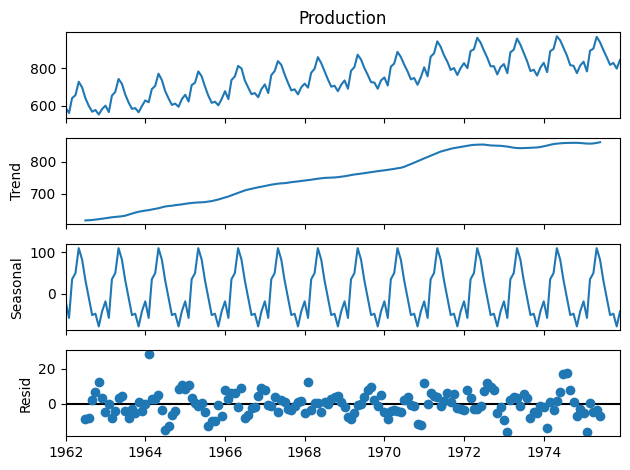

In [14]:
results = seasonal_decompose(df['Production']) # This shows the seasonality, trend and residual(noise) attributes of the data
results.plot();

If we ignore trend and seasonality from the data then we get residual (noise)

# **Scaling and Splitting**

In [15]:
len(df)

168

168 months

In [16]:
# Train Test splitting

train = df.iloc[:156] # 1 to 156 months are taken as train data
test = df.iloc[156:] # 156 to 168 months are taken as test data

In [17]:
# Scaling data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [18]:
df.head(),df.tail() # Shows both head and tail (first and last 5 values)

(            Production
 Month                 
 1962-01-01       589.0
 1962-02-01       561.0
 1962-03-01       640.0
 1962-04-01       656.0
 1962-05-01       727.0,
             Production
 Month                 
 1975-08-01       858.0
 1975-09-01       817.0
 1975-10-01       827.0
 1975-11-01       797.0
 1975-12-01       843.0)

In [19]:
scaler.fit(train)                 # Fits the scaler to the training data. Test data shouldn't be used here
scaled_train = scaler.transform(train)   # This line transforms the training data using the fitted scaler
scaled_test = scaler.transform(test)     # This ensures that the scaling is consistent between the training and testing sets

In [20]:
scaled_train[:10] # checking the first 10 value.

array([[0.08653846],
       [0.01923077],
       [0.20913462],
       [0.24759615],
       [0.41826923],
       [0.34615385],
       [0.20913462],
       [0.11057692],
       [0.03605769],
       [0.05769231]])

sclaed_trian.head() doesn't work here because the scaled_train variable is a NumPy array due to applying scaler.transform() .  
Don't use command like  ``` test = scaler.transform(test)``` This will create problem later in the process



# **Model**

In [21]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
# TimeseriesGenerator prepares our time series data to fit(train) in the RNN or LSTM model
# It is used to convert a time series dataset into a supervised learning dataset

In [22]:
# Define generator
n_input = 3          # how many months will be considered for prediction of next month
n_features = 1       # each time step in the data has only one feature (milk production)
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)



```
train, train: The first argument is the data that will be used as input sequences (the look-back window),  
and the second argument is the data that will be used as the target values (what the model will try to predict).  
In this case, we're using the train dataset for both, meaning the generator will create sequences from the training data  
and the corresponding next value from the training data as the target.

length=n_input: Length of the input sequences.Here each input sequence will consist of 3 consecutive time steps.

batch_size=1: Number of samples per batch. A batch_size of 1 means that the generator will yield one  
input sequence and its corresponding target value at a time.
```



In [23]:
X, y = generator[0]     # The generator yields pairs of input sequences (X) and their corresponding target values (y)
print(f'Given the Array: \n{X.flatten()}')
print(f'Predicted this y: \n{y}')

Given the Array: 
[0.08653846 0.01923077 0.20913462]
Predicted this y: 
[[0.24759615]]


In [24]:
X.shape # The generator outputs X with a shape of (batch_size, length, n_features), which is (1, 3, 1) in this case

(1, 3, 1)

In [25]:
X

array([[[0.08653846],
        [0.01923077],
        [0.20913462]]])

In [26]:
# We do the same thing, but now instead for 12 months
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

 The generator will now consider the previous 12 time steps (months) as input to predict the next time step.

In [27]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [28]:
# Define Model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))

# If we use 2nd layer, we the first layer to return full sequence of outputs. So, we need to add return_sequences=True to the first LSTM layer.
#model.add(LSTM(60,activation='relu'))  # no input shape needed here

model.add(Dense(1)) # Predicts one month's output
model.compile(optimizer='adam', loss='mse') # mean squared error loss function

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


input_shape=(n_input, n_features): This defines the shape of the input data that the LSTM layer expects. n_input is the number of time steps in each input sequence (which you set to 12), and n_features is the number of features at each time step (which you set to 1)

In [29]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

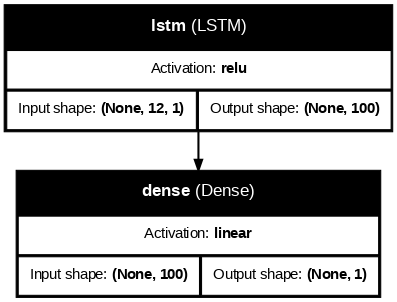

In [30]:
from keras.utils import plot_model
plot_model(model,dpi=75,show_shapes=True,show_layer_names=True,show_layer_activations=True)

In [31]:
# Fit model
model.fit(generator,epochs=50) # he fit() method will iterate through the data provided by the generator during training.

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0998
Epoch 2/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0269
Epoch 3/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0218
Epoch 4/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0119
Epoch 5/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0078
Epoch 6/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0079
Epoch 7/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0078
Epoch 8/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0060
Epoch 9/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0029
Epoch 10/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0030
Epoch 11/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0049
Epoch 12/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0046
Epoch 13/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0041
Epoch 14/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0049
Epoch 15/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss:

During the training process, the model will learn to map the input sequences (12 months of production data) to the target values (the next month's production) by adjusting its internal parameters to minimize the specified loss function (Mean Squared Error).

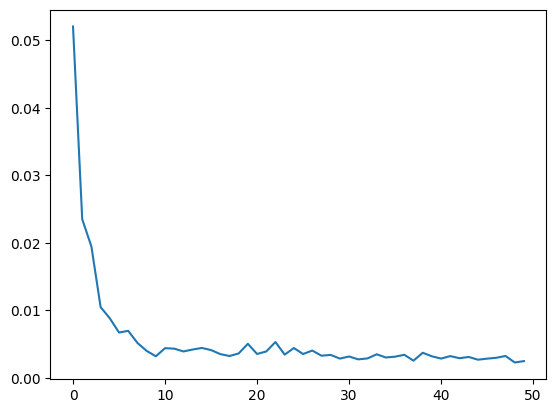

In [32]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)  # range(len(loss_per_epoch)) represents epoch number

After 20 epochs (nearly) , loss didn't change much

# **Prediction Generate**

In [33]:
last_train_batch = scaled_train[-12:] # last 12 month is taken
last_train_batch = last_train_batch.reshape((1, n_input, n_features)) # 1 is the batch size
model.predict(last_train_batch) # 157th month's prediction is generated

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


array([[0.70901245]], dtype=float32)

In [34]:
scaled_test[0] # test set starts from 157th month. So, we will compare is with the prediction

array([0.67548077])

In [35]:
# Doing the same task for the whole dataset

test_prediction = [] # empty list to store predicted value

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features)) # reshapes the initial input sequence into the format expected by the LSTM model

for i in range(len(test)):

  # get the prediction value for the first batch
  current_pred = model.predict(current_batch)[0] # model.predict() gives an array. [0] is used to access the value in the array

  # append the prediction into the array
  test_prediction.append(current_pred)

  # use the prediction to update the batch and remove the first value
  current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1) # It updates the current_batch for the next iteration

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


current_batch[:,1:,:] - This slices the current_batch to remove the first element (the oldest time step).

[[current_pred]] - This is the newly predicted value, reshaped to match the dimensions needed to be appended.  

np.append(..., axis=1) - This uses NumPy's append function to add the current_pred to the end of the updated current_batch along the second axis (axis=1), effectively sliding the input window forward by one time step.

In [36]:
test_prediction

[array([0.70901245], dtype=float32),
 array([0.70732594], dtype=float32),
 array([0.9149217], dtype=float32),
 array([0.99215406], dtype=float32),
 array([1.0496837], dtype=float32),
 array([1.0212604], dtype=float32),
 array([0.95111644], dtype=float32),
 array([0.85862476], dtype=float32),
 array([0.73400986], dtype=float32),
 array([0.69290483], dtype=float32),
 array([0.6425026], dtype=float32),
 array([0.700984], dtype=float32)]

In [37]:
test.head()

,Production
Month,
1975-01-01,834.0
1975-02-01,782.0
1975-03-01,892.0
1975-04-01,903.0
1975-05-01,966.0


**We have to rescale the data to evaluate**

# **Rescaling and Evaluating**

In [38]:
# Scaling back to the true predicted values
true_prediction = scaler.inverse_transform(test_prediction)

In [39]:
test['Prediction'] = true_prediction # adding a new column named 'Prediction' to the test variable and assign the true_prediction values to it

/tmp/ipython-input-39-1903236877.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Prediction'] = true_prediction # adding a new column named 'Prediction' to the test variable and assign the true_prediction values to it


<Axes: xlabel='Month'>

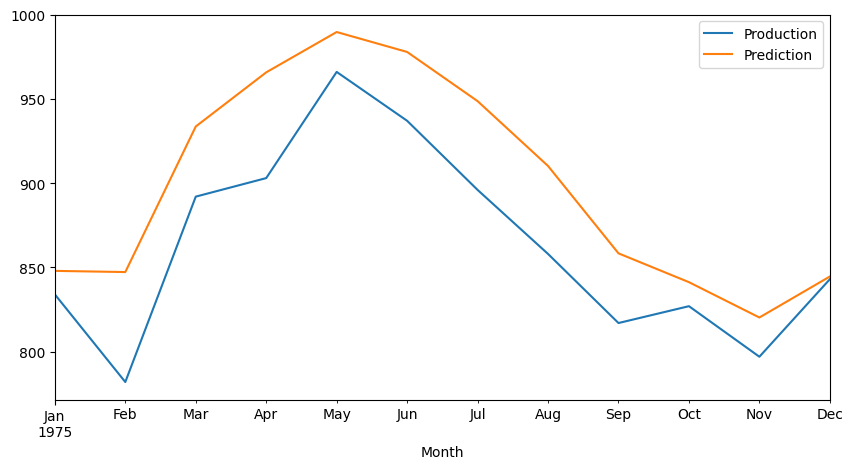

In [40]:
test.plot(figsize=(10,5))

In [41]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(test['Production'], test['Prediction']))
print(rmse) # root mean square error

41.1315737492697


The RMSE of 25.45118491457663(changeable) means that, on average, your model's predictions for monthly milk production in the test set were off by approximately 25.45(changeable) pounds per cow.